In [1]:
import tqdm
import itertools

import datamol as dm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mood.constants import DOWNSTREAM_RESULTS_DIR
from mood.dataset import MOOD_DATASETS
from mood.representations import MOOD_REPRESENTATIONS
from mood.baselines import SUPPORTED_BASELINES
from mood.utils import get_outlier_bounds
from mood.metrics import Metric

In [2]:
SUBDIR = "20221213"

In [3]:
in_dir = dm.fs.join(DOWNSTREAM_RESULTS_DIR, "dataframes", "compare_performance", SUBDIR)
pattern = dm.fs.join(in_dir, "gap_*.csv")
paths = dm.fs.glob(pattern)

In [4]:
def find_missing(paths, all_triplets):
    triplets = []
    for path in paths:
        path = dm.fs.get_basename(path)
        path = ".".join(path.split(".")[:-1])
        triplet = tuple(path.split("_")[1:])
        triplets.append(triplet)
    missing = set(all_triplets) - set(triplets)
    
    msg = f"Missing {len(missing)}:\n"
    for m in sorted(missing): 
        msg += f"{m}\n"
    return msg 
                        

all_triplets = list(itertools.product(MOOD_DATASETS, SUPPORTED_BASELINES, MOOD_REPRESENTATIONS))
assert list(all_triplets) == len(paths), find_missing(paths, all_triplets)

AssertionError: Missing 6:
('CYP2C9', 'GP', 'ChemBERTa')
('CYP2C9', 'GP', 'Desc2D')
('CYP2C9', 'GP', 'ECFP6')
('CYP2C9', 'GP', 'Graphormer')
('CYP2C9', 'GP', 'MACCS')
('Lipophilicity', 'RF', 'Graphormer')


In [5]:
df_original = pd.concat([pd.read_csv(p) for p in tqdm.tqdm(paths)], ignore_index=True)
# The "P450" is actually not informative, but these results were generated before abbreviating the name
df_original["dataset"] = df_original["dataset"].apply(lambda x: "CYP2C9" if x == "CYPP4502C9" else x)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:36<00:00,  5.20it/s]


In [6]:
df_original.groupby(["type", "metric"])[["iid_score", "ood_score"]].describe()

iid_score                                            \
                            count       mean        std       min       25%   
type        metric                                                            
calibration Brier score     103.0   0.349966   0.115566  0.075731  0.276674   
            Spearman         89.0   0.231079   0.179731 -0.215391  0.100010   
performance AUROC           103.0   0.751058   0.074654  0.495633  0.715765   
            MAE              89.0  16.604456  26.888342  0.307306  0.616072   

                                                          ood_score  \
                               50%        75%         max     count   
type        metric                                                    
calibration Brier score   0.360556   0.406835    0.755181     103.0   
            Spearman      0.202837   0.357643    0.673074      89.0   
performance AUROC         0.754444   0.804271    0.886833     103.0   
            MAE          10.063283  23.139135  231.291733      89.0   

                                                                              \
                              mean        std       min       25%        50%   
type        metric                                                             
calibration Brier score   0.360103   0.124103  0.078527  0.287558   0.363218   
            Spearman      0.182274   0.188168 -0.187380  0.031849   0.160010   
performance AUROC         0.716728   0.068756  0.497653  0.687080   0.726050   
            MAE          17.196870  21.413282  0.311015  0.750816  11.442899   

                                                
                               75%         max  
type        metric                              
calibration Brier score   0.431972    0.763074  
            Spearman      0.296355    0.676177  
performance AUROC         0.760365    0.875109  
            MAE          28.778414  159.147614

In [7]:
# Make a copy to keep the original intact. 
# Useful for experimentation, as creating the dataframe can be slow
df = df_original.copy()

# Upscale the Spearman correlation to go from [-1, 1] to [0, 1]
df.loc[df["metric"] == "Spearman", "iid_score"] = (df["iid_score"] + 1) / 2
df.loc[df["metric"] == "Spearman", "ood_score"] = (df["ood_score"] + 1) / 2

# A gap > 0; performance on OOD set was better
# We expect: Performance to be worse (so: Negative gaps)
df["gap"] = df["ood_score"] - df["iid_score"]

# Since we observed above that there is no negative scores
# We can also compute the relative change
# This is useful as the range to values for all targets is not the same (e.g. PPBR vs. Caco-2)
df["relative_gap"] = (df["gap"] / df["iid_score"]) * 100

# Invert the gap of metrics that need to be minimized, so that a high gap is always better
df["metric_direction"] = df["metric"].apply(lambda x: Metric.by_name(x).mode)
df.loc[df["gap"] == "min", "gap"] = -df["gap"]
df.loc[df["metric_direction"] == "min", "relative_gap"] = -df["relative_gap"]

df = df.rename(columns={"representation": "Representation", "dataset": "Dataset"})
df.head()

,Dataset,algorithm,Representation,iid_score,ood_score,metric,type,gap,relative_gap,metric_direction
0,BBB,GP,ChemBERTa,0.777683,0.703392,AUROC,performance,-0.074291,-9.552875,max
1,BBB,GP,ChemBERTa,0.532443,0.576794,Brier score,calibration,0.044352,-8.329877,min
2,BBB,GP,Desc2D,0.782846,0.785730,AUROC,performance,0.002884,0.368380,max
3,BBB,GP,Desc2D,0.441239,0.440911,Brier score,calibration,-0.000328,0.074418,min
4,BBB,GP,ECFP6,0.782923,0.610287,AUROC,performance,-0.172636,-22.050209,max


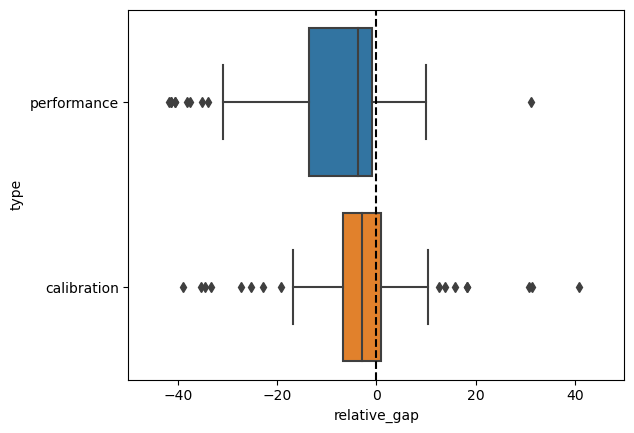

In [8]:
ax = sns.boxplot(data=df, x="relative_gap", y="type")
ax.set_xlim([-50, 50])
ax.plot([0, 0], ax.get_ylim(), "k--")

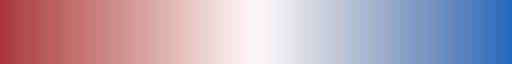

In [9]:
cmap = sns.color_palette("vlag_r", as_cmap=True)
cmap

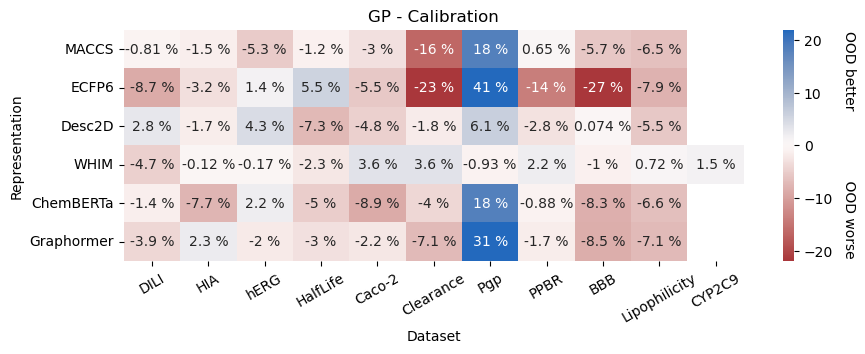

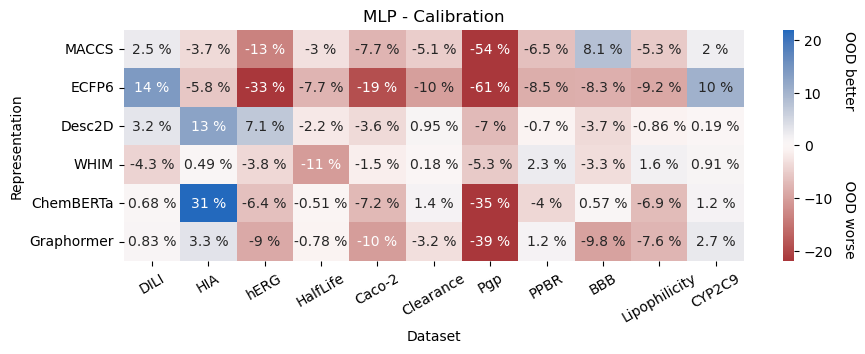

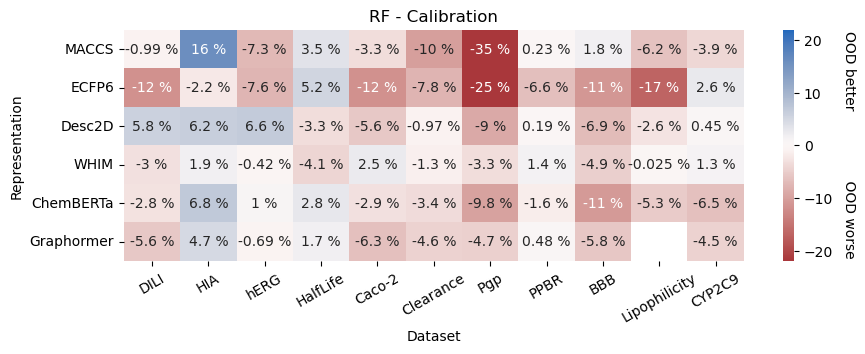

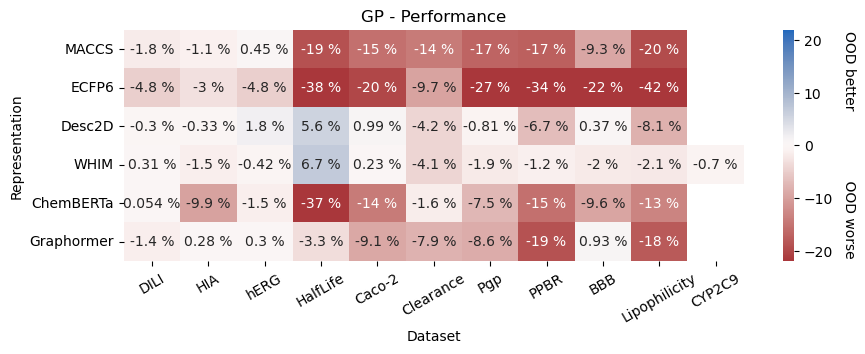

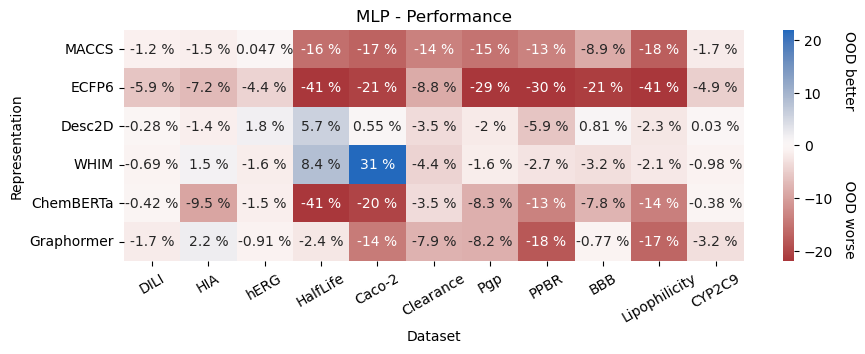

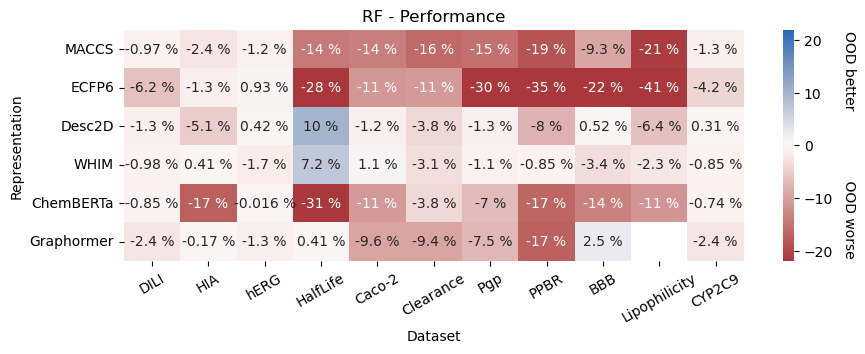

In [10]:
metric = "relative_gap"

lower, upper = get_outlier_bounds(df[metric].to_numpy())
vmin = min(lower, -upper)
vmax = -vmin

for metric_type, metric_group in df.groupby("type"):
        
    for idx, (name, group) in enumerate(metric_group.groupby("algorithm")):
        fig, ax = plt.subplots(figsize=(10, 3))
        pivot = group.pivot("Representation", "Dataset", metric)
        
        for c in MOOD_DATASETS: 
            if c not in pivot.columns:
                pivot[c] = np.nan
        pivot = pivot[MOOD_DATASETS]
        pivot = pivot.reindex(MOOD_REPRESENTATIONS)
        
        sns.heatmap(pivot, annot=True, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for t in ax.texts: t.set_text(t.get_text() + " %")
        ax.set_title(f"{name} - {metric_type.capitalize()}")
        ax.text(
            0.85, 
            0.5, 
            f"{'OOD better':25} OOD worse", 
            rotation=-90, 
            ha="center", 
            va="center", 
            transform=fig.transFigure
        )

The End.